In [3]:
import os

import pandas as pd
import numpy as np

import matplotlib as mpl

width = 5
height = width/1.618

mpl.rcParams.update({
    'font.size': 12,
    'figure.figsize': (width, height), 
    'figure.facecolor': 'white', 
    'savefig.dpi': 360, 
    'figure.subplot.bottom': 0.0, 
    'figure.edgecolor': 'white',
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
})

import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

cmap = mpl.colormaps["Accent"]

In [4]:
def load_and_process(path, mode="max", topk_tournament=None, max_steps=1000):
    assert mode in ["min", "max"]
    df = pd.read_csv(path)
    
    if df.objective.dtype != np.float64:
        m = df.objective.str.startswith("F")
        df.loc[m,"objective"] = df.loc[m,"objective"].replace("F", "-1000000")
        df = df.astype({"objective": float})
        
    
    if "m:budget" not in df.columns:
        df["m:budget"] = max_steps
        
    if mode == "min":
        df["objective"] = np.negative(df["objective"])
        if "m:objective_val" in df.columns:
            df["m:objective_val"] = np.negative(df["m:objective_val"])
        df["m:objective_test"] = np.negative(df["m:objective_test"])

    if topk_tournament:
        k = topk_tournament
        max_idx = []
        df["m:budget_cumsum"] = df["m:budget"].cumsum()
        for i in range(len(df)):
            if mode == "max":
                topk = df[:i+1].nlargest(n=k, columns="objective")
                if k == 1:
                    winner = topk
                else:
                    winner = topk.nlargest(n=1, columns="m:objective_val")
            else:
                topk = df[:i+1].nsmallest(n=k, columns="objective")
                if k == 1:
                    winner = topk
                else:
                    winner = topk.nsmallest(n=1, columns="m:objective_val")
                
            # consider that checkpointed "weights" can be reloaded
            # df.loc[i,"m:budget_cumsum"] = df.loc[i,"m:budget_cumsum"] + len(topk) * 100 - topk["m:budget"].sum()
            
            # consider that selected models are retrained from scratch
            df.loc[i,"m:budget_cumsum"] = df.loc[i,"m:budget_cumsum"] + len(topk) * max_teps
            
            winner_idx = winner.index.tolist()[0]
            max_idx.append(winner_idx)
        
        df["max_idx"] = max_idx
        
    else:
        if mode == "max":
            df["objective_cummax"] = df["objective"].cummax()
        else:
            df["objective_cummax"] = df["objective"].cummin()
        
        df["m:budget_cumsum"] = df["m:timestamp_gather"].cumsum()
        df["idx"] = df.index
        df = df.merge(df.groupby("objective_cummax")[["idx"]].first().reset_index(), on="objective_cummax")
        df.rename(columns={"idx_y": "max_idx"}, inplace=True)
        df.index  = df.idx_x.values
        del df["idx_x"]
        
        # for idx in df["max_idx"]:
        #     if df.loc[idx, "m:budget"] < max_steps:
        #         df.loc[idx, "m:budget_cumsum"] = df.loc[idx, "m:budget_cumsum"] + max_steps
                
    return df

In [12]:
path = {
    "Max Epochs": "PINN/results-original.csv",
    "1-Epoch": "PINN/results-1ep.csv",
    "RoBER": "PINN/results-RoBER.csv",
}

duration Max Epochs: 9.768075722323523 for 500 evaluations
duration 1-Epoch: 0.26801065557532844 for 500 evaluations
duration RoBER: 1.5462310390339957 for 500 evaluations


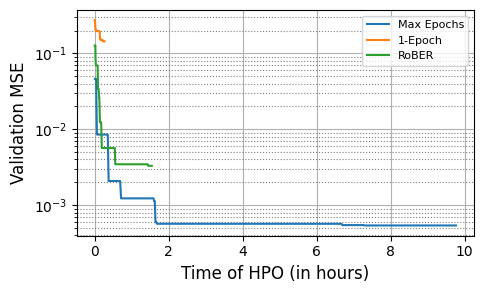

In [13]:
plt.figure()

for label, path_i in path.items():
    df = load_and_process(path_i)

    # x = np.arange(1, len(df)+1)
    x = df["m:timestamp_gather"]/3600
    print(f"duration {label}: {max(x)} for {len(x)} evaluations")
    y = df["objective_cummax"].values
    plt.plot(x, -y, label=label)
    
plt.xlabel("Time of HPO (in hours)")
plt.ylabel("Validation MSE")
plt.grid()
plt.grid(visible=True, which="minor", color="gray", linestyle=":")
plt.yscale("log")
# plt.xscale("log")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()

In [14]:
df

,p:activation,p:alpha,p:hidden_dim,p:lr,p:num_layers,objective,job_id,m:timestamp_submit,m:timestamp_gather,m:timestamp_start,m:timestamp_end,m:budget,m:stopped,m:infos_stopped,objective_cummax,m:budget_cumsum,max_idx
0,tanh,0.500000,5,0.010000,5,-0.127164,0,0.010072,10.978123,1.674587e+09,1.674587e+09,16,True,prob=0.991,-0.127164,1.097812e+01,0
1,gelu,3.713304,6,0.005023,17,-0.361578,1,11.022661,19.636322,1.674587e+09,1.674587e+09,4,True,prob=1.000,-0.127164,3.061445e+01,0
2,gelu,0.022570,29,0.006412,11,-0.360449,2,19.840472,26.038411,1.674587e+09,1.674587e+09,4,True,prob=0.997,-0.127164,5.665286e+01,0
3,relu,1.331623,46,0.000147,5,-0.358726,3,26.229309,28.940635,1.674587e+09,1.674587e+09,4,True,prob=0.992,-0.127164,8.559349e+01,0
4,tanh,0.409831,23,0.008091,8,-0.347405,4,28.980834,31.952650,1.674587e+09,1.674587e+09,4,True,prob=0.992,-0.127164,1.175461e+02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,elu,0.070950,11,0.002157,15,-0.167840,495,5548.088456,5551.452051,1.674592e+09,1.674592e+09,4,True,prob=0.994,-0.003302,1.276939e+06,450
496,tanh,0.086976,12,0.008658,14,-0.284755,496,5551.807321,5555.060443,1.674592e+09,1.674592e+09,4,True,prob=1.000,-0.003302,1.282494e+06,450
497,tanh,0.071285,12,0.002071,13,-0.316852,497,5555.419243,5558.763650,1.674592e+09,1.674592e+09,4,True,prob=0.950,-0.003302,1.288052e+06,450
498,tanh,0.130679,12,0.003081,17,-0.310005,498,5559.121524,5562.650847,1.674592e+09,1.674592e+09,4,True,prob=0.928,-0.003302,1.293615e+06,450


In [18]:
df["m:budget"].sum()

79950

## Best Configurations

### Max Epochs

The config objective is: `-0.0005`

The best config is:

```json
{
    'p:activation': 'gelu', 
    'p:alpha': 0.0713803616024727, 
    'p:hidden_dim': 50, 
    'p:lr': 0.009112203892205, 
    'p:num_layers': 12, 
    'objective': 
    '-0.0005399304791353643', 
    'job_id': 383, 
    'm:timestamp_submit': 26184.98286652565, 
    'm:timestamp_gather': 26274.531222343445, 
    'm:timestamp_start': 1674624498.234779, 
    'm:timestamp_end': 1674624587.782676
}
```
The validation objective is:  `0.0005`
The test score is `0.0006`

It consumed $500 \times 1000 = 500,000$ epochs.

### 1-Epoch

It took `600` seconds to train the Top-10.

- Top 1
The config objective is: -0.1441845297813415
validation objective is:  0.36154312
The test score is 0.36669694037327005

- Top 2
The config objective is: -0.1465161144733429
validation objective is:  0.1848228
The test score is 0.18753577900319876

- Top 3
The config objective is: -0.1482401937246322
validation objective is:  0.36153245
The test score is 0.3666539357624952

- Top 4
The config objective is: -0.1494192630052566
validation objective is:  0.15364476
The test score is 0.15687768100211275

- Top 5
The config objective is: -0.1498761177062988
validation objective is:  1.2439098
The test score is 1.2632346182827376

- Top  6
The config objective is: -0.1500376015901565
validation objective is:  0.105650514
The test score is 0.10716873865152582

- Top  7 **BEST**
The config objective is: -0.1525050103664398
validation objective is:  0.10096738
The test score is 0.10365394122311057

- Top  8
The config objective is: -0.1535067409276962
validation objective is:  1.9763694
The test score is 2.0042068044779198

- Top  9
The config objective is: -0.1559061557054519
validation objective is:  0.18439232
The test score is 0.18750179429388106

- Top  10
The config objective is: -0.1560664772987365
validation objective is:  0.1450143
The test score is 0.14761773033209133

It consumed $500 \times 1 + 10 \times 1000 = 10,500$ epochs.

In [20]:
(964+600)/3600

0.43444444444444447

### RoBER

The config objective is: `-0.003`

The best config is
```json
{
    'p:activation': 'tanh',
    'p:alpha': 0.0838861310333266,
    'p:hidden_dim': 12,
    'p:lr': 0.0021977431445454,
    'p:num_layers': 15,
    'objective': -0.0033016205,
    'job_id': 450,
    'm:timestamp_submit': 5155.318133831024,
    'm:timestamp_gather': 5200.669605016708,
    'm:timestamp_start': 1674591899.3460655,
    'm:timestamp_end': 1674591944.6966605,
    'm:budget': 1000,
    'm:stopped': False,
    'm:infos_stopped': 'max steps reached'
}
```

The validation objective is:  `0.003`
The testing MSE is `0.0035`

It consumed $79,950$ epochs.